# [オンライン開催]機械学習と異常検知第8回
機械学習における時系列データとは、特定期間にわたって連続する一連のデータ点の集合となります。時間は、秒、分、時間、日、週、年といった単位で扱われるのが一般的です。  
  
時系列モデルはデータセットを分析し、時系列なデータの中から意味のあるデータ特性を抽出します。

これにより、モデルはデータからパターンを理解し、有用な情報を得ることができます。モデルは、得られた知識を使用して将来の予測を行います。時系列モデリングでは、図とプロットを使用して予測値を示します。  

時系列の応用例としては、天気予報、株価予測、外国為替取引、科学・工学分野などがあります。  

時系列モデルを構築する場合、データセットに異常や外れ値が含まれる可能性があります。  
異常とは、通常の動作から逸脱したデータ点となります。データセット内で異常が検出されないままであると、モデルのパフォーマンスに悪影響を及ぼします。今回では、[Prophet](https://facebook.github.io/prophet/docs/quick_start.html) を使用して異常検出モデルを構築します。  

  
※参考: [Tutorial : Time Series Forecasting with Prophet](https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet)

## 時系列データの用意とゴール
`nyc_taxi.csv`  
ニューヨーク市で活動しているタクシー運転手の数を 30 分ごとに示しています。

このデータセットを使用して、Prophet を使用して時系列モデルを構築します。次に、モデルを使用して、ニューヨークのアクティブなタクシー運転手の数を予測します。モデルの予測後、予測の結果を分析します。これにより、異常/外れ値を検出できるようになります。  
散布図を使用すると、これらの外れ値を視覚化できます。外れ値は、予想される予測値から逸脱した値をいいます  
 (極端に高いか低い可能性があります)。

## パッケージのインポート
パッケージは異常検出にとって重要です。これらの各パッケージの機能は次のとおりです。

*   **matplotlib**:  
 `Matplotlib` は視覚化パッケージです。 `Matplotlib` を使用して、折れ線グラフ、図、ダイアグラムをプロットできます。  

*   **numpy**:  
 `Numpy` は時系列データセットを配列に変換します。また、配列に対して数学的演算を実行することもできます。  

*   **pandas**:  
 `Pandas` はデータの分析と操作を実行できます。  

*   **os**:  
 `Google Colab` にいるときにオペレーティングシステムと対話できるようにします。  

*   **datetime**:  
 データセット内のタイムスタンプを `DateTime` データ型に変換します。時系列モデルは、時間列の `DateTime` データ型でのみ機能します。  

*   **plotly.express**:  
 よりインタラクティブな図をプロットします。`Plotly` を使用すると、図をズームできるため、より多くの洞察を得ることができます。

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import plotly.express as px

## データセットの読み込み


In [4]:
# 読み込み
df = pd.read_csv('nyc_taxi.csv', encoding="utf-8")

In [7]:
# データの中身を確認
df = df.drop("Unnamed: 0", axis=1)
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


画像からわかるように、データセットには 2つの列があります。タイムスタンプと値の列。タイムスタンプ列には 30分間隔があります。値の列には、30分ごとのアクティブなタクシー運転手の数が表示されます。データセットには 10320行があります。
  
次のコードを使用して、"timestamp"列を `datetime` 型に変換する必要があります。

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

### データセットを 1 時間間隔に変更
データセットには 10320 のサンプル数があります。この値は非常に大きいため、視覚化するのが難しい場合があります。データセットを再サンプリングし、1時間間隔に変更する必要があります。これにより、観測値が半分に減り、視覚化が容易になります。

In [ ]:
df = df.set_index('timestamp').resample("H").mean()

In [ ]:
df

,value
timestamp,
2014-07-01 00:00:00,9485.5
2014-07-01 01:00:00,5433.0
2014-07-01 02:00:00,3346.5
2014-07-01 03:00:00,2216.5
2014-07-01 04:00:00,2189.5
...,...
2015-01-31 19:00:00,28288.5
2015-01-31 20:00:00,24138.0
2015-01-31 21:00:00,24194.5


上の画像から、データセットを再サンプリングしました。新しいインデックス数は 5160 です。

### 折れ線グラフをプロットする
このデータセットを折れ線グラフを使用して視覚化します。この図を、`plotly.express` ライブラリを使用してプロットします。  
  
上記のコードから、X 軸をタイムスタンプとして初期化します。 y 軸は値です。そして折れ線グラフのタイトルは「NYC Taxi Demand」です。次に、1 年以内、3 年以内、または 5 年以内のデータ ポイントを表示できるラベルを追加します。

図を以下に示します。

In [ ]:
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi Demand')
fig.update_xaxes(
 rangeslider_visible=True,
 rangeselector=dict(
 buttons=list([
 dict(count=1, label='1y', step='year', stepmode='backward'),
 dict(count=2, label='3y', step='year', stepmode='backward'),
 dict(count=3, label='5y', step='year', stepmode='backward'),
 dict(step='all')
        ])
    )
)
fig.show()

上の画像は、2014 年 7 月から 2015 年 1 月までのタクシーの稼働台数を示しています。  
  
このデータセットを使用して時系列モデルを構築しましょう。

## Prophet を始める

In [ ]:
!python -m pip install prophet

In [ ]:
from prophet import Prophet

In [ ]:
taxi_df = df.reset_index()[['timestamp', 'value']].rename({'timestamp':'ds',
 'value':'y'},
 axis='columns')

上記のコードでは、'timestamp'列の名前を `ds` に、値列の名前を `y` に変更しました。名前が変更されたデータセットの構造を確認するには、次のコードを使用します。

In [ ]:
taxi_df.head()

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


### データセットの分割
データセットを 2 つのセットに分割する必要があります。 1 つのセットは時系列モデルのトレーニング用であり、もう 1 つのセットはモデルのテスト用です。

In [ ]:
train_dataset = taxi_df[(taxi_df['ds']>='2014-07-01')&(taxi_df['ds']<='2015-01-27')]
test_dataset = taxi_df[(taxi_df['ds']>'2015-01-27')]

上記のコードから、2014-07-01 から 2015-01-27 までのデータセットが学習用データセットです。テスト セットには、2015 年 1 月 27 日以降の値が含まれています。モデルはテスト データセットを使用して予測を行います。

モデルを初期化しましょう。

### Initializing the model
次のコードを使用してモデルを初期化します。  
  
出力の信頼区間を増やすために、`changepoint_range=0.95` を使用します。信頼区間によって、予測が正しいか間違っているかが決まります。信頼区間が大きくなるほど、モデルが正確な予測を行う可能性が高くなります。

モデルをトレーニング データセットに適合させてみましょう。

In [ ]:
model = Prophet(changepoint_range=0.95)

### Model fitting
モデルがトレーニング データセットから学習できるように、モデルをトレーニング データセットに適合させます。

In [ ]:
model.fit(train_dataset)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6scgbuz/d0se69xk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6scgbuz/i8mdzy4o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82945', 'data', 'file=/tmp/tmpk6scgbuz/d0se69xk.json', 'init=/tmp/tmpk6scgbuz/i8mdzy4o.json', 'output', 'file=/tmp/tmpk6scgbuz/prophet_modeldphgrrh_/prophet_model-20230810234919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:49:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:49:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


上記コードによって、モデルをトレーニングします。トレーニング後、モデルは将来の予測を行うことができるようになります。

### テスト データセットを使用した"未知"の予測
テスト データセットには、2015 年 1 月 27 日以降の値が含まれています。テストデータセットの期間は 120 時間分です。テストデータセットでは 120 時間の予測を行っています。

In [ ]:
future = model.make_future_dataframe(periods=120, freq='H')
future.tail()

,ds
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00
5159,2015-01-31 23:00:00
5160,2015-02-01 00:00:00


上記のコードの period=120 は、テスト データセットに記録された 120 時間を示します。 `freq='H'` は、1 時間間隔で予測値を提供します。 `future.tail()` は、ds 列の最後の 5 行を表示します。モデルが予測する過去 5 時間を示します。

予測を行うには、次のコードを使用します。

In [ ]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5156,2015-01-31 20:00:00,24356.945956,19571.939863,28876.942109
5157,2015-01-31 21:00:00,23233.645964,18178.863090,28188.870097
5158,2015-01-31 22:00:00,21041.671137,16421.884125,26132.437927
5159,2015-01-31 23:00:00,18514.484936,13458.170246,23350.383885
5160,2015-02-01 00:00:00,15787.194785,11182.741834,20465.993217


上記のコードから、さまざまなメソッドと列を初期化しました。

*   model.predict:   
実際の予測を行うメソッド。
*   ds:   
 120 時間のタイムスタンプ値が含まれる列。
*   yhat:   
モデルが予測を行った後の予測値が含まれる列。
*   yhat_ lower:   
信頼区間の下限値を含む列。
*   yhat_upper:   
信頼区間の上限値を含む列。

## 可視化

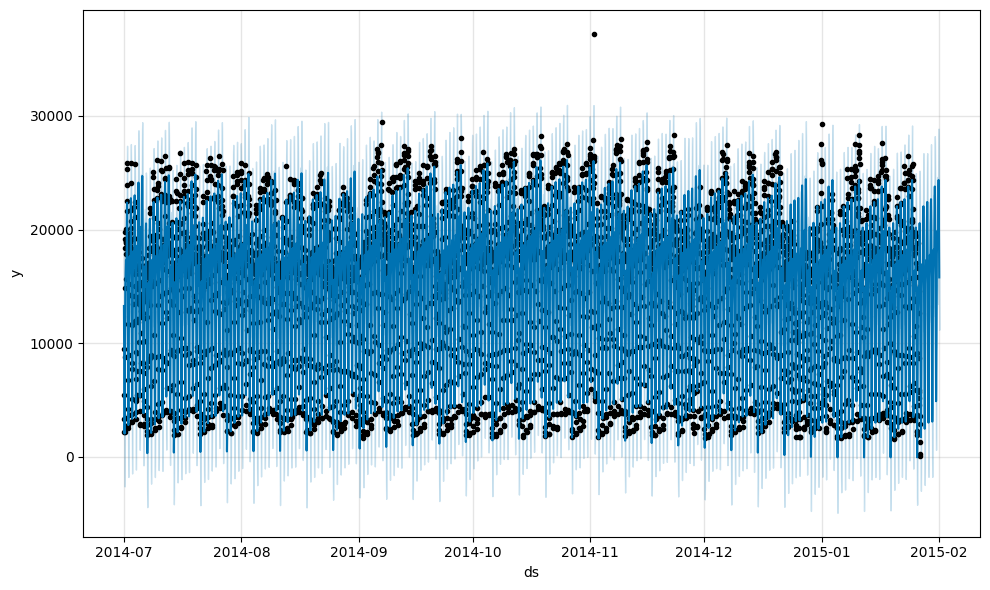

In [ ]:
digram1 = model.plot(forecast)

上の画像では、黒い点が予測値です。次に、これらの値を分析して、これらの値の異常を検出する必要があります。

## 予測値の分析
これらの予測結果をさらに理解するために、予測データ フレームに 2 つの列を追加します。これまでのところ、予測データ フレームには 4 つの列があります。誤差列と不確実性列を追加する必要があります。これら 2 つの列は、異常/外れ値の検出に役立ちます。

### Errorの列
`Error`という列を追加して、実際のタクシーの台数と予測されたタクシーの台数の差を求めます。実測値は y 列になり、予測値は yhat 列になります。

In [ ]:
outcome = pd.merge(taxi_df,forecast, on='ds')

In [ ]:
outcome

,ds,y,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-07-01 00:00:00,9485.5,14698.084179,8671.546439,18129.670281,14698.084179,14698.084179,-1426.330675,-1426.330675,-1426.330675,-118.034625,-118.034625,-118.034625,-1308.296050,-1308.296050,-1308.296050,0.0,0.0,0.0,13271.753504
1,2014-07-01 01:00:00,5433.0,14698.418809,5826.798838,14845.105538,14698.418809,14698.418809,-4435.112788,-4435.112788,-4435.112788,-3226.124792,-3226.124792,-3226.124792,-1208.987997,-1208.987997,-1208.987997,0.0,0.0,0.0,10263.306021
2,2014-07-01 02:00:00,3346.5,14698.753439,2260.936153,11328.041410,14698.753439,14698.753439,-7999.013240,-7999.013240,-7999.013240,-6885.963140,-6885.963140,-6885.963140,-1113.050100,-1113.050100,-1113.050100,0.0,0.0,0.0,6699.740199
3,2014-07-01 03:00:00,2216.5,14699.088069,-1087.584646,8486.942373,14699.088069,14699.088069,-11220.562482,-11220.562482,-11220.562482,-10199.503135,-10199.503135,-10199.503135,-1021.059347,-1021.059347,-1021.059347,0.0,0.0,0.0,3478.525588
4,2014-07-01 04:00:00,2189.5,14699.422699,-2601.387748,7205.846228,14699.422699,14699.422699,-12651.717240,-12651.717240,-12651.717240,-11718.201621,-11718.201621,-11718.201621,-933.515619,-933.515619,-933.515619,0.0,0.0,0.0,2047.705460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,14382.092430,18891.962541,28398.377533,14374.749871,14390.404441,9410.803651,9410.803651,9410.803651,7236.172046,7236.172046,7236.172046,2174.631605,2174.631605,2174.631605,0.0,0.0,0.0,23792.896081
5156,2015-01-31 20:00:00,24138.0,14382.098114,19571.939863,28876.942109,14374.681528,14390.573158,9974.847842,9974.847842,9974.847842,7906.291427,7906.291427,7906.291427,2068.556416,2068.556416,2068.556416,0.0,0.0,0.0,24356.945956
5157,2015-01-31 21:00:00,24194.5,14382.103798,18178.863090,28188.870097,14374.608206,14390.640758,8851.542166,8851.542166,8851.542166,6901.753703,6901.753703,6901.753703,1949.788463,1949.788463,1949.788463,0.0,0.0,0.0,23233.645964
5158,2015-01-31 22:00:00,26515.0,14382.109482,16421.884125,26132.437927,14374.409216,14390.735964,6659.561655,6659.561655,6659.561655,4840.709983,4840.709983,4840.709983,1818.851673,1818.851673,1818.851673,0.0,0.0,0.0,21041.671137


次のコードを使用して `Error`列を追加します。

In [ ]:
outcome['error'] = outcome['y'] - outcome['yhat']

### 不確実性の列
信頼区間 (yhat_upper と yhat_ lower) 間の差から、`不確実性` を定義します、

次のコードを使用して、`uncertainity`列を追加します。

In [ ]:
outcome['uncertainity'] = outcome['yhat_upper'] - outcome['yhat_lower']

In [ ]:
outcome.head()

,ds,y,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,...,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,error,uncertainity
0,2014-07-01 00:00:00,9485.5,14698.084179,8671.546439,18129.670281,14698.084179,14698.084179,-1426.330675,-1426.330675,-1426.330675,...,-118.034625,-1308.296050,-1308.296050,-1308.296050,0.0,0.0,0.0,13271.753504,-3786.253504,9458.123842
1,2014-07-01 01:00:00,5433.0,14698.418809,5826.798838,14845.105538,14698.418809,14698.418809,-4435.112788,-4435.112788,-4435.112788,...,-3226.124792,-1208.987997,-1208.987997,-1208.987997,0.0,0.0,0.0,10263.306021,-4830.306021,9018.306699
2,2014-07-01 02:00:00,3346.5,14698.753439,2260.936153,11328.041410,14698.753439,14698.753439,-7999.013240,-7999.013240,-7999.013240,...,-6885.963140,-1113.050100,-1113.050100,-1113.050100,0.0,0.0,0.0,6699.740199,-3353.240199,9067.105256
3,2014-07-01 03:00:00,2216.5,14699.088069,-1087.584646,8486.942373,14699.088069,14699.088069,-11220.562482,-11220.562482,-11220.562482,...,-10199.503135,-1021.059347,-1021.059347,-1021.059347,0.0,0.0,0.0,3478.525588,-1262.025588,9574.527019
4,2014-07-01 04:00:00,2189.5,14699.422699,-2601.387748,7205.846228,14699.422699,14699.422699,-12651.717240,-12651.717240,-12651.717240,...,-11718.201621,-933.515619,-933.515619,-933.515619,0.0,0.0,0.0,2047.705460,141.794540,9807.233976


これらの列を使用して異常を検出します。

## 異常検知
次のロジックを使用して異常を特定します。

In [ ]:
outcome['anomaly'] = outcome.apply(lambda x: 'Yes' if(np.abs(x['error'])>1.5*x['uncertainity']) else 'No',axis=1)

上記のコードから、絶対誤差値 (error) が 1.5 に不確実性値を乗算した値より大きい場合、予測値 yhat は異常であると定義します。 `outout.apply` メソッドにより、定義されたロジックを適用し、異常検出します。

これで、検出された異常を示す散布図を作成できるようになりました。

### 散布図による可視化

In [ ]:
fig = px.scatter(outcome.reset_index(), x='ds', y='y',
 color='anomaly',title='NYC Taxi Demand')
fig.update_xaxes(
 rangeslider_visible=True,
 rangeselector=dict(
 buttons=list([
 dict(count=1, label='1y', step='year', stepmode='backward'),
 dict(count=2, label='3y', step='year', stepmode='backward'),
 dict(count=3, label='5y', step='year', stepmode='backward'),
 dict(step='all')
        ])
    )
)
fig.show()

上の画像では、検出された異常が赤色で表示されています。通常のデータ点は青色です。



##
最終回では、前回同様、時系列データの異常検出について学びました。モデルのトレーニングにはニューヨーク タクシー データセットを使用しました。 Prophet ライブラリを使用して、時系列モデルを構築しました。このモデルは、ニューヨークのアクティブなタクシー運転手の数を予測するために利用しつつ、次に、散布図を使用してデータセット内の異常を検出しました。実際の現場では、異常検出のために上記一連の作業を実施するかと思います。